### **Aplicação e comparação dos métodos de Mínimos quadrados, Lasso e Ridge**

---

Gabriel Oukawa <br>
Álgebra linear para ciência de dados <br>
2º Semestre de 2025

---


In [ ]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

---
**Conjunto de dados utilizado (regressão):**

- **Variável resposta:** temperatura do ar medida em intervalos horários
- **Variáveis independentes (*features*, total de 21 variáveis):**
  - **Meteorológicas e radiativas:** umidade relativa (RH), velocidade do vento (WS), pressão atmosférica (P), radiação solar incidente (RAD), dissipação da camada limite (BLD), altura da camada limite (BLH), energia convectiva potencial disponível (CAPE) e índice K (KINX)
  - **Atmosféricas e hidrológicas:** cobertura de nuvens alta (HCC), média (MCC) e baixa (LCC), coluna total de vapor d’água (TCWV), precipitação acumulada (RAIN) e direção do vento (WD, em oito setores)

---

In [ ]:
# Carregar os dados
df = pd.read_csv('air-temperature_hourly.csv')

df = df.dropna()

print(df.head())
print(df.shape)

               date      RH     WS        P         RAD          BLD  \
0  24/12/2011 05:00  80.875  0.950  945.775    4.916667  1956.007646   
1  24/12/2011 06:00  83.675  0.800  946.475  124.500000  1807.332279   
2  24/12/2011 07:00  73.950  0.725  946.975  315.750000  2067.254250   
3  24/12/2011 08:00  64.250  1.525  947.450  510.916667  3241.061873   
4  24/12/2011 09:00  59.125  2.650  947.650  671.416667  4460.615762   

          BLH        CAPE       KINX       HCC  ...       TCWV  RAIN  WD_NE  \
0  190.291060  375.912476  32.707008  0.334595  ...  41.925390   0.0      0   
1  171.064181  426.754983  33.200420  0.042376  ...  42.132401   0.0      0   
2  326.939236  375.279820  33.543068  0.003708  ...  41.685937   0.0      0   
3  532.202015  354.862298  33.901134  0.006241  ...  42.062110   0.0      1   
4  799.899330  424.914531  34.257488  0.018937  ...  42.082193   0.0      1   

   WD_E  WD_SE  WD_S  WD_SW  WD_W  WD_NW         T  
0     1      0     0      0     0      

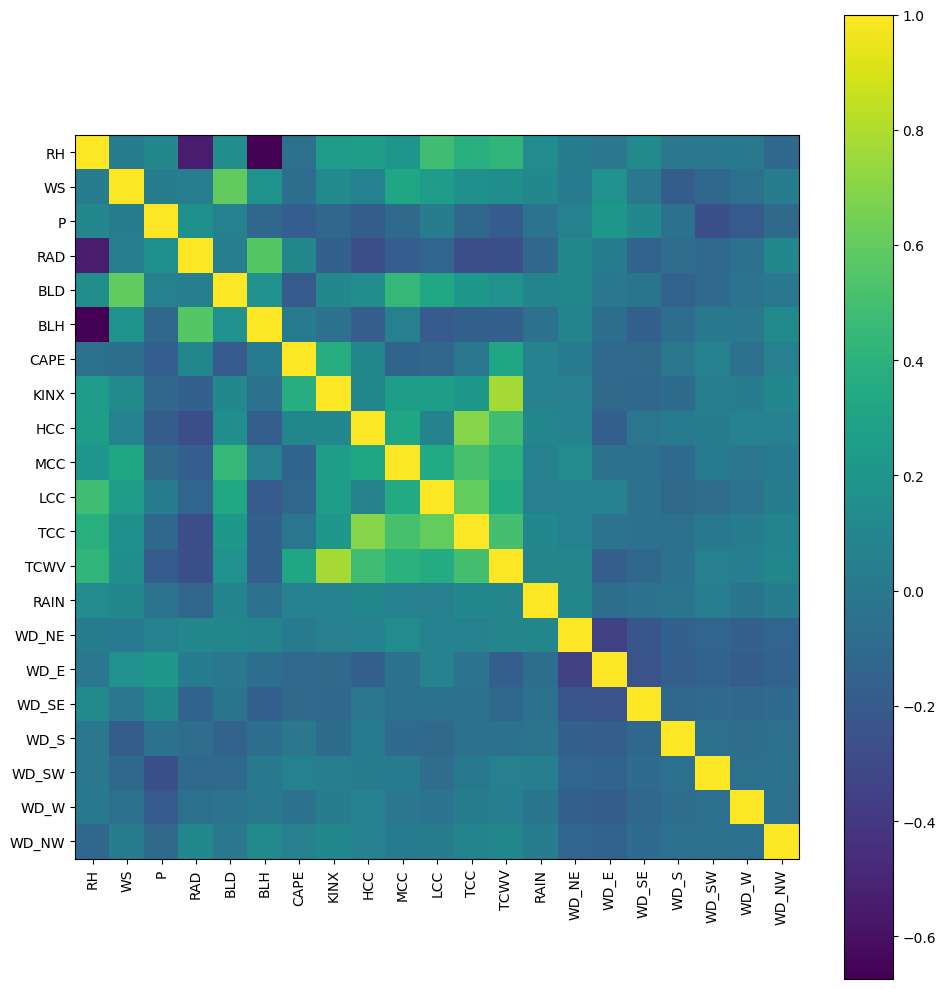

In [ ]:
# Matriz de correlação
X = df.drop(columns=['date', 'T'], errors='ignore')

corr = X.corr()

plt.figure(figsize=(10, 10))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

Intercepto: 25.215932842448993
Coeficientes:
RH      -3.346530
BLD     -0.375899
P       -0.325227
WD_SE   -0.045472
RAIN    -0.035665
KINX    -0.021874
RAD      0.001615
WD_SW    0.012603
HCC      0.017927
WS       0.021799
WD_S     0.030420
TCC      0.030803
WD_NW    0.064862
WD_W     0.068175
LCC      0.080214
MCC      0.093027
WD_E     0.149012
WD_NE    0.322428
CAPE     0.419803
BLH      0.646779
TCWV     0.856013
dtype: float64
R²: 0.9168436340636151
RMSE: 1.1263097302454184


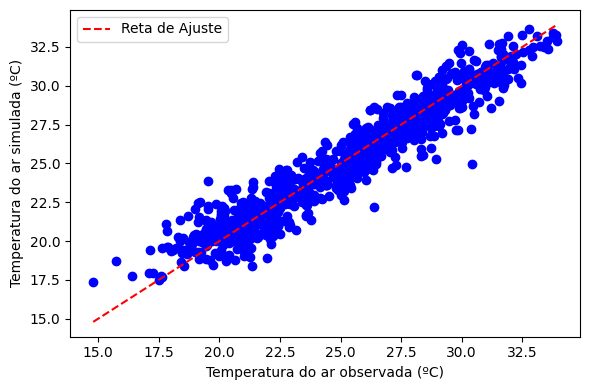

In [25]:
# Implementação dos mínimos quadrados (regressão linear)
Y = df['T'].values

X = df.drop(columns=['date', 'T'], errors='ignore')
X = X.select_dtypes(include='number')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

regressor = LinearRegression(fit_intercept=True)
regressor.fit(X_scaled, Y)

intercept = regressor.intercept_
coefficients = pd.Series(regressor.coef_, index=X.columns)

print('Intercepto:', intercept)
print('Coeficientes:')
print(coefficients.sort_values())

Y_hat = regressor.predict(X_scaled)

r2 = regressor.score(X_scaled, Y)
rmse = np.sqrt(np.mean((Y - Y_hat)**2))

print('R²:', r2)
print('RMSE:', rmse)

plt.figure(figsize=(6, 4))
plt.scatter(Y, Y_hat, color='blue', label='')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', label='Reta de Ajuste')
plt.xlabel('Temperatura do ar observada (ºC)')
plt.ylabel('Temperatura do ar simulada (ºC)')
plt.legend()
plt.tight_layout()
plt.show()

Com o método dos **mínimos quadrados**, observa-se um alto poder explicativo (R² ≈ 0,92), com erro médio (RMSE) relativamente baixo, em torno de 1,1 °C.

Entretanto, o ajuste considera todas as 21 variáveis, e já é possível identificar que algumas apresentam contribuição praticamente nula, conforme os coeficientes estimados:

- KINX: -0.002181  
- BLD: -0.000080  
- RAD:  0.000005  
- CAPE: 0.000790  
- BLH:  0.001135


Intercepto: 25.21593284244899
Coeficientes mantidos pelo LASSO:
RH      -3.213913
P       -0.269674
BLD     -0.192853
WD_SE   -0.093874
WD_NE    0.139962
CAPE     0.359248
BLH      0.587767
TCWV     0.755132
dtype: float64
R²: 0.9107683212622487
RMSE: 1.166727990391878


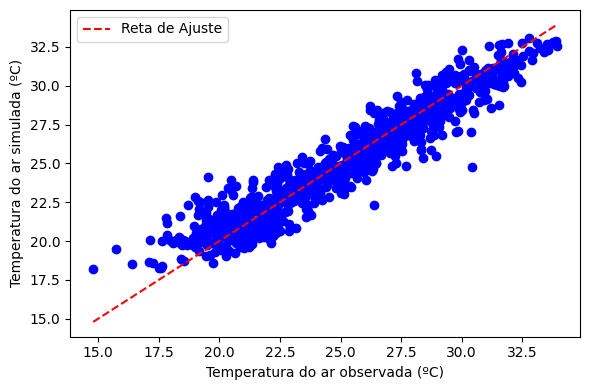

In [26]:
Y = df['T'].values

X = df.drop(columns=['date', 'T'], errors='ignore')
X = X.select_dtypes(include='number')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(
    alpha=0.1,
    fit_intercept=True,
    max_iter=10000
)

lasso.fit(X_scaled, Y)

intercept = lasso.intercept_

coefficients = pd.Series(lasso.coef_, index=X.columns)
coefficients = coefficients[coefficients != 0].sort_values()

print('Intercepto:', intercept)
print('Coeficientes mantidos pelo LASSO:')
print(coefficients)

Y_hat = lasso.predict(X_scaled)

r2 = 1 - np.sum((Y - Y_hat)**2) / np.sum((Y - Y.mean())**2)
rmse = np.sqrt(np.mean((Y - Y_hat)**2))

print('R²:', r2)
print('RMSE:', rmse)

plt.figure(figsize=(6, 4))
plt.scatter(Y, Y_hat, color='blue', label='')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', label='Reta de Ajuste')
plt.xlabel('Temperatura do ar observada (ºC)')
plt.ylabel('Temperatura do ar simulada (ºC)')
plt.legend()
plt.tight_layout()
plt.show()

Com o **Lasso**, o modelo mantém um bom poder explicativo (R² ≈ 0,91), com erro médio de aproximadamente 1,2 °C, valores próximos aos obtidos com mínimos quadrados.

A principal diferença está na regularização L1, que reduz o número das variáveis zerando os coeficientes. Dos 21 preditores iniciais, apenas 8 foram preservados: **RH**, **P**, **BLD**, **WD (SE)**, **WD (NE)**, **CAPE**, **BLH**, **TCWV**.


Intercepto: 25.215932842448993
Coeficientes mantidos pelo RIDGE:
RH      -3.345385
BLD     -0.375991
P       -0.325355
WD_SE   -0.045719
RAIN    -0.035729
KINX    -0.021477
RAD      0.001940
WD_SW    0.012486
HCC      0.017921
WS       0.021887
WD_S     0.030304
TCC      0.031061
WD_NW    0.064810
WD_W     0.068021
LCC      0.079765
MCC      0.093033
WD_E     0.148757
WD_NE    0.322163
CAPE     0.419751
BLH      0.647091
TCWV     0.855267
dtype: float64
R²: 0.9168436032703441
RMSE: 1.1263099387848199


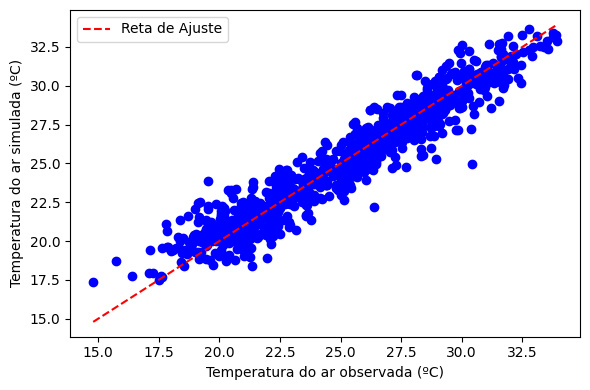

In [27]:
Y = df['T'].values

X = df.drop(columns=['date', 'T'], errors='ignore')
X = X.select_dtypes(include='number')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

ridge = Ridge(
    alpha=0.1,
    fit_intercept=True,
    max_iter=10000
)

ridge.fit(X_scaled, Y)

intercept = ridge.intercept_

coefficients = pd.Series(ridge.coef_, index=X.columns)
coefficients = coefficients[coefficients != 0].sort_values()

print('Intercepto:', intercept)
print('Coeficientes mantidos pelo RIDGE:')
print(coefficients)

Y_hat = ridge.predict(X_scaled)

r2 = 1 - np.sum((Y - Y_hat)**2) / np.sum((Y - Y.mean())**2)
rmse = np.sqrt(np.mean((Y - Y_hat)**2))

print('R²:', r2)
print('RMSE:', rmse)

plt.figure(figsize=(6, 4))
plt.scatter(Y, Y_hat, color='blue', label='')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], color='red', linestyle='--', label='Reta de Ajuste')
plt.xlabel('Temperatura do ar observada (ºC)')
plt.ylabel('Temperatura do ar simulada (ºC)')
plt.legend()
plt.tight_layout()
plt.show()

No método **Ridge**, o modelo tem o mesmo poder explicativo (R² ≈ 0,92) e erro médio (1,1 °C) em comparação com o método dos mínimos quadrados.

Com a regularização L2, as seguintes variáveis (13 no total) tiveram um coeficiente reduzido para próximo de zero:
- WD (SE): -0.046  
- RAIN: -0.036  
- KINX: -0.021  
- RAD:   0.002  
- WD (SW): 0.012  
- HCC:  0.018  
- WS:   0.022  
- WD (S): 0.030  
- TCC:  0.031  
- WD (NW): 0.065  
- WD (W):  0.068  
- LCC:  0.080  
- MCC:  0.093  